# Zero-noise extrapolation via quantum circuit unoptimization

Code that implements the elementary recipe from "Quantum Circuit Unoptimization" ([arXiv:2311.03805](https://arxiv.org/pdf/2311.03805)).

**Idea**: ZNE is a quantum error mitigation technique that involves running the same circuit at different noise levels and extrapolating the results to estimate the zero-noise limit. It relies on artificially amplifying the noise in the circuit and fitting the results to a model. 

Unoptimizing a circuit increases its depth and gate count, which can lead to higher noise due to increased opportunities for errors. By deliberately adding gates that do not change the overall computation, we can amplify the noise without altering the circuit's functionality.

## Preliminaries

In [1]:
# Standard library imports.
from collections import namedtuple
import functools
import random
import warnings

# Third-party library imports for scientific computing and data handling.
import numpy as np

# Quantum computing framework imports.
from qiskit_aer import AerSimulator
from qiskit_aer.noise import amplitude_damping_error, depolarizing_error, NoiseModel
from qiskit.circuit.library import UnitaryGate

from qiskit import QuantumCircuit, transpile
from qiskit.providers import Backend
from qiskit.quantum_info import random_unitary, Operator
from qiskit.transpiler.passes import Decompose
from qiskit.transpiler import PassManager

# Mitiq for quantum error mitigation.
from mitiq import zne

### Noise models

Define depolarizing and amplitude dampening noise models for testing.

In [2]:
def amplitude_damping_noise_model(prob_1: float = 0.04, prob_2: float = 0.08) -> NoiseModel:
    """Defines an amplitude damping noise model with one-qubit and two-qubit errors.
    
    Args:
        prob_1: One-qubit gate error rate (default 4%).
        prob_2: Two-qubit gate error rate (default 8%).
    Returns:
        Amplitude damping noise model.
    """
    # Quantum errors
    error_1 = amplitude_damping_error(param_amp=prob_1, excited_state_population=1)

    error_2 = amplitude_damping_error(param_amp=prob_2, excited_state_population=1)
    error_2 = error_2.tensor(error_2)

    # Add errors to noise model
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ["u1", "u2", "u3"])
    noise_model.add_all_qubit_quantum_error(error_2, ["cx"])
    
    return noise_model

In [3]:
def depolarizing_noise_model(error: float = 0.01) -> NoiseModel:
    """Defines an depolarizing noise model with one-qubit.

    Args:
        error: One-qubit gate error rate (default 1%).
    Returns:
        Depolarizing noise model.
    """
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error, 1), ["u1", "u2", "u3"])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error, 2), "cx")
    
    return noise_model

### Random circuit generation

We also require a way of generating a random circuit consisting of two-qubit gates.

In [4]:
def random_two_qubit_circuit(num_qubits: int, depth: int) -> QuantumCircuit:
    """Generate a random quantum circuit with two-qubit gates.

    Args:
        num_qubits: The number of qubits in the circuit.
        depth: The number of layers (depth) of two-qubit gates.

    Returns:
        The generated random circuit.
    """
    qc = QuantumCircuit(num_qubits)

    # Map gate names to their corresponding methods
    gate_map = {
        "cx": qc.cx,
        "cz": qc.cz,
        "swap": qc.swap,
        "iswap": qc.iswap
    }

    for _ in range(depth):
        qubit1, qubit2 = random.sample(range(num_qubits), 2)
        gate = random.choice(list(gate_map.keys()))
        gate_map[gate](qubit1, qubit2)

    return qc

As an example, here is randomly generated 5-qubit and depth-10 circuit consisting of two-qubit gates 

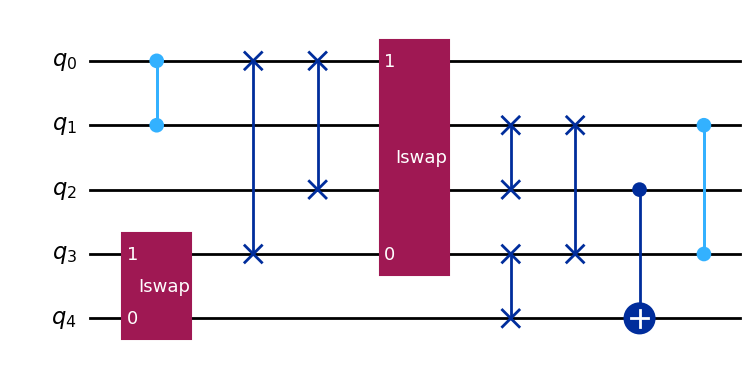

In [5]:
num_qubits = 5
depth = 10
random_circuit = random_two_qubit_circuit(num_qubits, depth)

random_circuit.draw("mpl")

## Elementary recipe

The elementary recipe (ER) for quantum circuit unoptimization is given by Figure-1 in [arXiv:2311.03805](https://arxiv.org/pdf/2311.03805). The ER contains the following steps (applied in the following order):

1. Gate insertion
2. Gate swapping
3. Gate decomposition
4. Gate synthesis

### Gate insertion

In [6]:
def gate_insert(qc: QuantumCircuit, strategy="P_c"):
    """Insert a two-qubit gate A and its Hermitian conjugate A† between two gates B1 and B2.
    Args:
        qc: The input quantum circuit.
        strategy: The strategy to select the pair of two-qubit gates. Options are "P_c" or "P_r".

    Returns:
        new_qc: The modified quantum circuit with A and A† inserted.
        B1_info: Information about gate B1 (index, qubits, gate).
    """
    # Collect all two-qubit gates with their indices and qubits
    two_qubit_gates = []

    for idx, instruction in enumerate(qc.data):
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits

        if len(qargs) == 2:
            qubit_indices = [qc.find_bit(qarg).index for qarg in qargs]
            two_qubit_gates.append({"index": idx, "qubits": qubit_indices, "gate": instr})

    found_pair = False
    B1_idx = B1_qubits = B1_gate = shared_qubit = None 

    if strategy == "P_c":
        # Strategy P_c: Find a pair of gates that share a common qubit
        for i in range(len(two_qubit_gates)):
            for j in range(i + 1, len(two_qubit_gates)):
                qubits_i = set(two_qubit_gates[i]["qubits"])
                qubits_j = set(two_qubit_gates[j]["qubits"])
                common_qubits = qubits_i & qubits_j
                
                if len(common_qubits) == 1:
                    B1_idx = two_qubit_gates[i]["index"]
                    B1_qubits = two_qubit_gates[i]["qubits"]
                    B1_gate = two_qubit_gates[i]["gate"]
                    shared_qubit = list(common_qubits)[0]
                    found_pair = True
                    break

            if found_pair:
                break

    elif strategy == "P_r":
        # Strategy P_r: Randomly select a two-qubit gate as B1
        if two_qubit_gates:
            gate_info = random.choice(two_qubit_gates)
            B1_idx = gate_info["index"]
            B1_qubits = gate_info["qubits"]
            B1_gate = gate_info["gate"]
            shared_qubit = B1_qubits[0]  # Choose the first qubit as shared
            found_pair = True
    else:
        raise ValueError(f"Unknown strategy '{strategy}'. Available strategies are 'P_c' and 'P_r'.")

    if not found_pair:
        warnings.warn("No suitable pair of two-qubit gates found. Skipping gate insertion.")
        return qc, None  # Return the original circuit unmodified

    # Generate a random two-qubit unitary A and its adjoint A†
    A = random_unitary(4)
    A_dag = A.adjoint()

    # Choose qubits for A and A† insertion
    all_qubits = set(range(qc.num_qubits))
    other_qubits = list(all_qubits - set(B1_qubits))

    if not other_qubits:
        warnings.warn("Not enough qubits to perform gate insertion. Skipping.")
        return qc, None  # Return the original circuit unmodified

    third_qubit = other_qubits[0]
    shared_qubit = shared_qubit

    # Map indices back to qubits
    qubit_map = {qc.find_bit(q).index: q for q in qc.qubits}

    # Create a new circuit and insert A and A†
    new_qc = QuantumCircuit(*qc.qregs, *qc.cregs)

    # Copy the gates up to and including B1
    for instruction in qc.data[: B1_idx + 1]:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        new_qc.append(instr, qargs, cargs)

    # Insert A on qubits [shared_qubit, third_qubit]
    qubits_for_A = [qubit_map[shared_qubit], qubit_map[third_qubit]]

    ## modified! ##
    # Insert A†, A on the same qubits
    new_qc.unitary(A_dag, qubits_for_A, label=r"$A^{\dagger}$")
    new_qc.unitary(A, qubits_for_A, label="A")
    ###############

    # Copy the remaining gates
    for instruction in qc.data[B1_idx + 1 :]:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        new_qc.append(instr, qargs, cargs)

    # Prepare B1_info for gate_swap function
    B1_info = {
        "index": B1_idx,
        "qubits": B1_qubits,
        "gate": B1_gate,
        "shared_qubit": shared_qubit,
        "third_qubit": third_qubit,
        "A": A,
        "A_dag": A_dag,
    }

    return new_qc, B1_info

In [7]:
qc = random_two_qubit_circuit(4, 5)
inserted_qc, B1_info = gate_insert(qc)

original_unitary = Operator(qc)
unoptimized_unitary_insert = Operator(inserted_qc)

unitaries_are_equal_insert = original_unitary.equiv(unoptimized_unitary_insert)

print(f"Are the circuits functionally equivalent (after insert)? {unitaries_are_equal_insert}")

Are the circuits functionally equivalent (after insert)? True


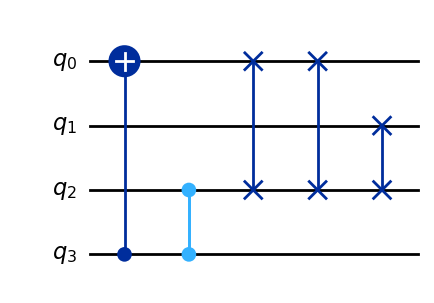

In [8]:
qc.draw("mpl")

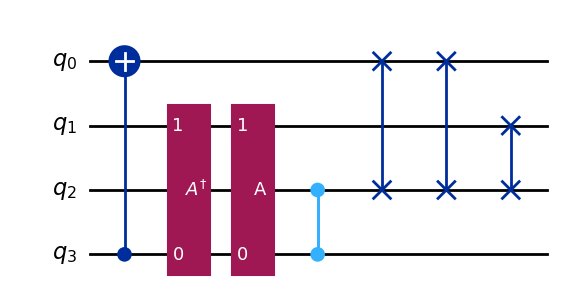

In [9]:
inserted_qc.draw("mpl")

### Gate swapping

In [10]:
def gate_swap(qc: QuantumCircuit, B1_info: dict) -> QuantumCircuit:
    r"""Swap the B1 gate with the A† gate in the circuit, replacing A† with \widetilde{A^\dagger}.
    Args:
        qc: The input quantum circuit.
        B1_info: Information about gate B1, including its index, qubits, and the A, A† gates.
    Returns:
        new_qc: The modified quantum circuit with B1 and A† swapped.
    """
    B1_idx = B1_info["index"]
    B1_qubits = B1_info["qubits"]
    B1_gate = B1_info["gate"]
    A = B1_info["A"]
    A_dag = B1_info["A_dag"]
    shared_qubit = B1_info["shared_qubit"]
    third_qubit = B1_info["third_qubit"]
    
    # Indices for A and A† in the circuit
    A_dag_idx = B1_idx + 1  # A† is inserted after B1
    A_idx = B1_idx + 2  # A is inserted after A†

    # Map qubit indices to qubit objects
    qubit_map = {qc.find_bit(q).index: q for q in qc.qubits}

    # Get the operators
    B1_operator = Operator(B1_gate)
    A_operator = Operator(A)
    A_dagger_operator = A_operator.adjoint()

    # Determine the qubits involved
    qubits_involved = sorted(set(B1_qubits + [shared_qubit, third_qubit]))
    qubits_involved_objs = [qubit_map[q] for q in qubits_involved]
    num_qubits_involved = len(qubits_involved)

    # Create mapping from qubit indices to positions
    qubit_positions = {q: idx for idx, q in enumerate(qubits_involved)}

    # Build B1_operator_full
    B1_operator_full = Operator(np.eye(2 ** num_qubits_involved))
    B1_qubit_positions = [qubit_positions[q] for q in B1_qubits]
    B1_operator_full = B1_operator_full.compose(B1_operator, qargs=B1_qubit_positions)

    # Build A_dagger_operator_full
    A_dagger_operator_full = Operator(np.eye(2 ** num_qubits_involved))
    A_dagger_qubits = [shared_qubit, third_qubit]
    A_dagger_qubit_positions = [qubit_positions[q] for q in A_dagger_qubits]
    A_dagger_operator_full = A_dagger_operator_full.compose(A_dagger_operator, qargs=A_dagger_qubit_positions)

    # Compute B1_operator_full_dagger
    B1_operator_full_dagger = B1_operator_full.adjoint()

    # Compute \widetilde{A^\dagger}
    widetilde_A_dagger_operator = B1_operator_full_dagger.dot(A_dagger_operator_full).dot(B1_operator_full)

    # Create UnitaryGate from \widetilde{A^\dagger}
    widetilde_A_dagger_gate = UnitaryGate(widetilde_A_dagger_operator.data, label=r"$\widetilde{A^{\dagger}}$")

    # Create a new quantum circuit
    new_qc = QuantumCircuit(*qc.qregs, *qc.cregs)

    # Copy the gates up to B1_idx
    for i in range(B1_idx):
        instruction = qc.data[i]
        new_qc.append(instruction.operation, instruction.qubits, instruction.clbits)

    # Insert \widetilde{A^\dagger} at position B1_idx
    new_qc.append(widetilde_A_dagger_gate, qubits_involved_objs)

    # Insert B1 gate at position B1_idx + 1
    new_qc.append(B1_gate, [qubit_map[q] for q in B1_qubits])

    # Copy the remaining gates, skipping the original A_dagger gate
    for i in range(B1_idx + 2, len(qc.data)):
        instruction = qc.data[i]
        new_qc.append(instruction.operation, instruction.qubits, instruction.clbits)

    return new_qc

In [11]:
qc = random_two_qubit_circuit(4, 5)
inserted_qc, B1_info = gate_insert(qc)
swapped_qc = gate_swap(inserted_qc, B1_info)

original_unitary = Operator(qc)
unoptimized_unitary_insert = Operator(inserted_qc)
unoptimized_unitary_swap = Operator(swapped_qc)

unitaries_are_equal_insert = original_unitary.equiv(unoptimized_unitary_insert)
unitaries_are_equal_swap = original_unitary.equiv(unoptimized_unitary_swap)

print(f"Are the circuits functionally equivalent (after insert)? {unitaries_are_equal_insert}")
print(f"Are the circuits functionally equivalent (after swap)? {unitaries_are_equal_swap}")

Are the circuits functionally equivalent (after insert)? True
Are the circuits functionally equivalent (after swap)? True


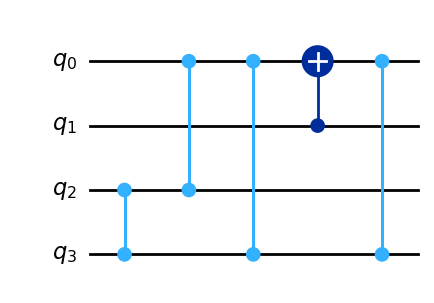

In [12]:
qc.draw("mpl")

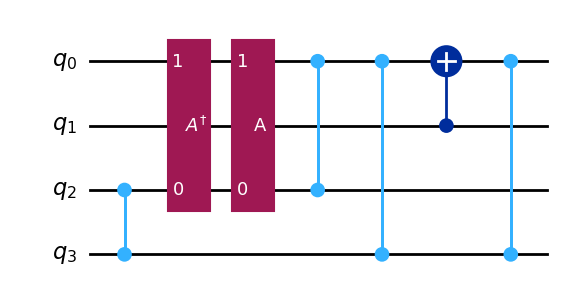

In [13]:
inserted_qc.draw("mpl")

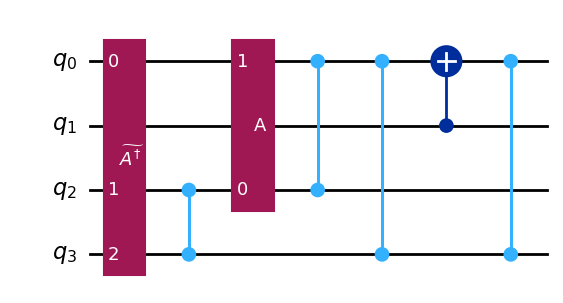

In [14]:
swapped_qc.draw("mpl")

### Gate decomposition

In [15]:
def decompose_circuit(qc: QuantumCircuit) -> QuantumCircuit:
    """Decompose multi-qubit unitary gates into elementary gates.

    Args:
        qc: The quantum circuit to decompose.

    Returns:
        new_qc: The decomposed quantum circuit.
    """
    # Create a PassManager and append the Decompose pass
    pass_manager = PassManager()
    pass_manager.append(Decompose())

    # Run the pass manager on your circuit
    return pass_manager.run(qc)

In [16]:
qc = random_two_qubit_circuit(4, 5)
inserted_qc, B1_info = gate_insert(qc)
swapped_qc = gate_swap(inserted_qc, B1_info)
decomposed_qc = decompose_circuit(swapped_qc)

original_unitary = Operator(qc)
unoptimized_unitary_insert = Operator(inserted_qc)
unoptimized_unitary_swap = Operator(swapped_qc)
unoptimized_unitary_decompose = Operator(decomposed_qc)

unitaries_are_equal_insert = original_unitary.equiv(unoptimized_unitary_insert)
unitaries_are_equal_swap = original_unitary.equiv(unoptimized_unitary_swap)
unitaries_are_equal_decompose = original_unitary.equiv(unoptimized_unitary_decompose)

print(f"Are the circuits functionally equivalent (after insert)? {unitaries_are_equal_insert}")
print(f"Are the circuits functionally equivalent (after swap)? {unitaries_are_equal_swap}")
print(f"Are the circuits functionally equivalent (after decompose)? {unitaries_are_equal_decompose}")

Are the circuits functionally equivalent (after insert)? True
Are the circuits functionally equivalent (after swap)? True
Are the circuits functionally equivalent (after decompose)? True


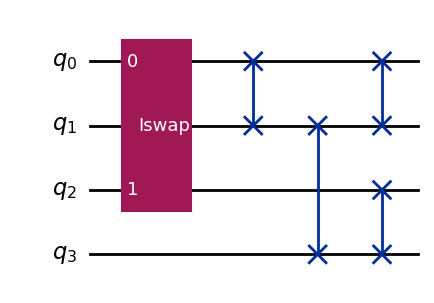

In [17]:
qc.draw("mpl")

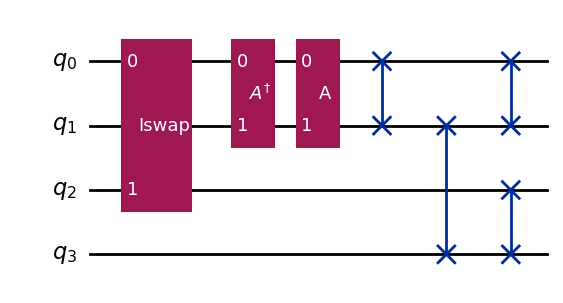

In [18]:
inserted_qc.draw("mpl")

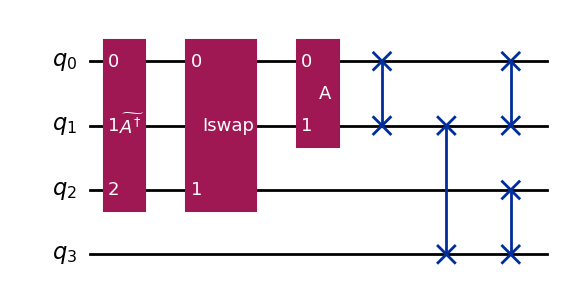

In [19]:
swapped_qc.draw("mpl")

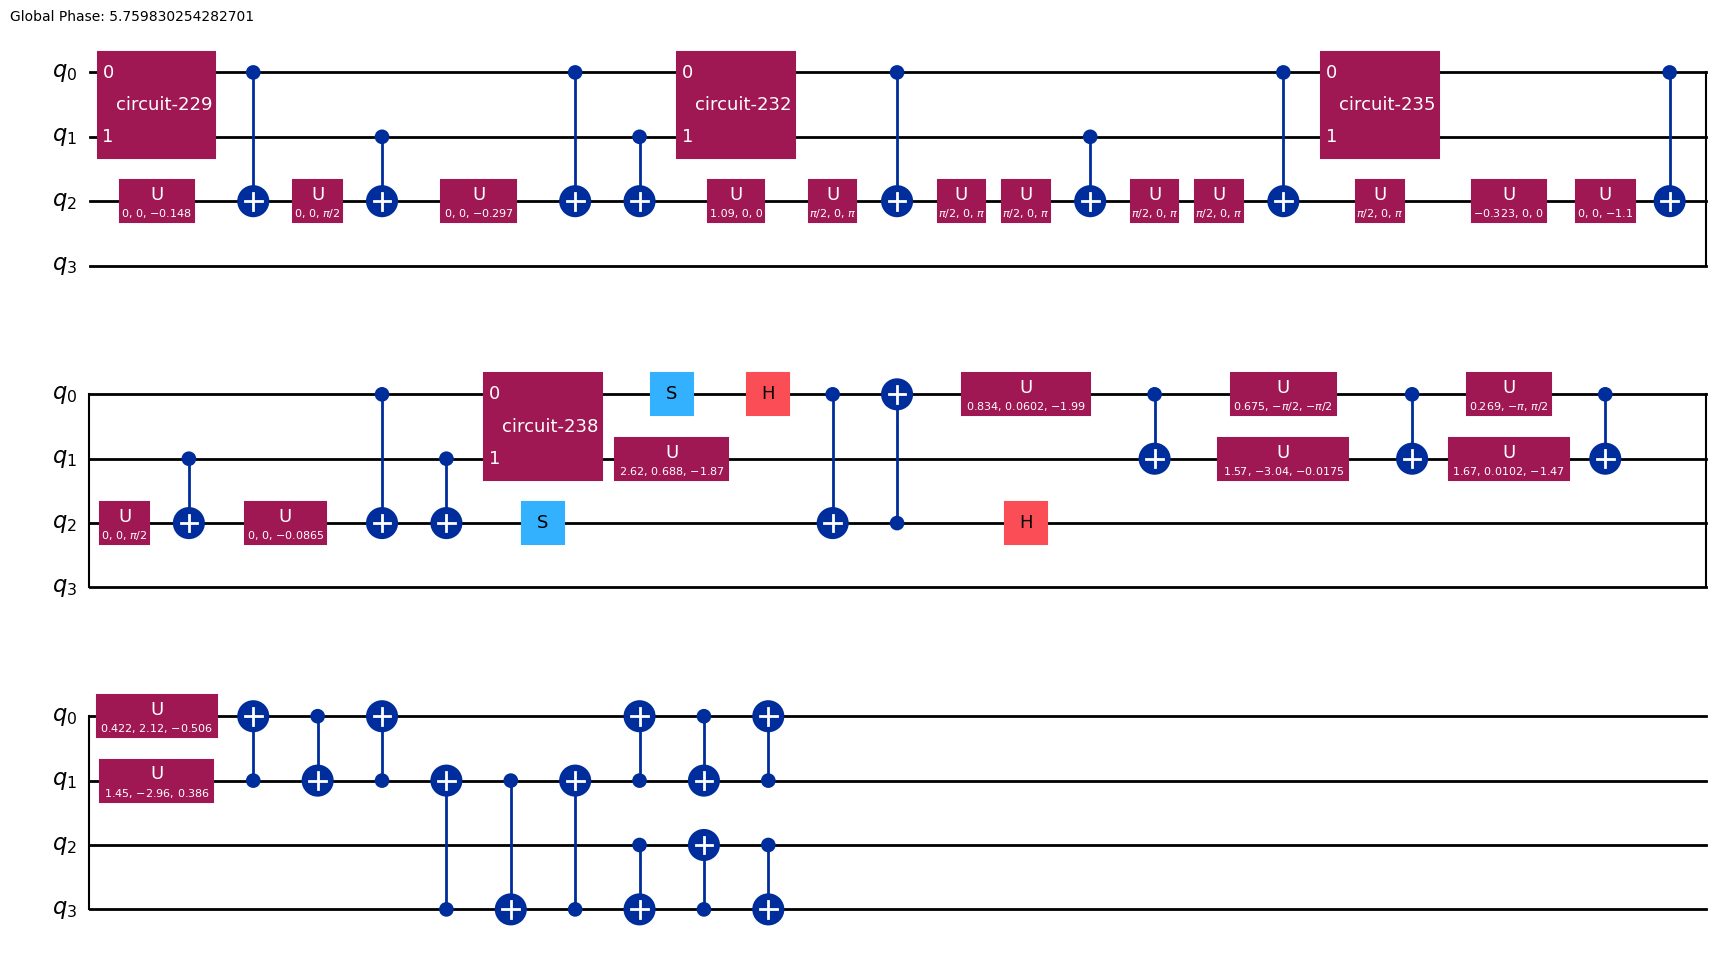

In [20]:
decomposed_qc.draw("mpl")

### Gate synthesis

In [21]:
def synthesize_circuit(qc: QuantumCircuit, optimization_level: int = 0) -> QuantumCircuit:
    """Synthesize the circuit using a specified optimization level.

    Args:
        qc: The quantum circuit to synthesize.
        optimization_level: The optimization level for transpilation.

    Returns:
        new_qc: The synthesized quantum circuit.
    """
    # Transpile the circuit to synthesize it
    return transpile(qc, optimization_level=optimization_level, basis_gates=["u1", "u2", "u3", "cx"])

In [22]:
qc = random_two_qubit_circuit(4, 5)
inserted_qc, B1_info = gate_insert(qc)
swapped_qc = gate_swap(inserted_qc, B1_info)
decomposed_qc = decompose_circuit(swapped_qc)
synthesized_qc = synthesize_circuit(decomposed_qc)

original_unitary = Operator(qc)
unoptimized_unitary_insert = Operator(inserted_qc)
unoptimized_unitary_swap = Operator(swapped_qc)
unoptimized_unitary_decompose = Operator(decomposed_qc)
unoptimized_unitary_synthesize = Operator(synthesized_qc)

unitaries_are_equal_insert = original_unitary.equiv(unoptimized_unitary_insert)
unitaries_are_equal_swap = original_unitary.equiv(unoptimized_unitary_swap)
unitaries_are_equal_decompose = original_unitary.equiv(unoptimized_unitary_decompose)
unitaries_are_equal_synthesize = original_unitary.equiv(unoptimized_unitary_synthesize)

print(f"Are the circuits functionally equivalent (after insert)? {unitaries_are_equal_insert}")
print(f"Are the circuits functionally equivalent (after swap)? {unitaries_are_equal_swap}")
print(f"Are the circuits functionally equivalent (after decompose)? {unitaries_are_equal_decompose}")
print(f"Are the circuits functionally equivalent (after synthesize)? {unitaries_are_equal_synthesize}")

Are the circuits functionally equivalent (after insert)? True
Are the circuits functionally equivalent (after swap)? True
Are the circuits functionally equivalent (after decompose)? True
Are the circuits functionally equivalent (after synthesize)? True


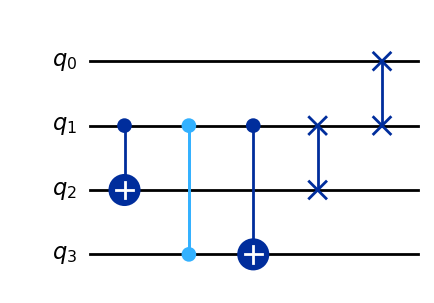

In [23]:
qc.draw("mpl")

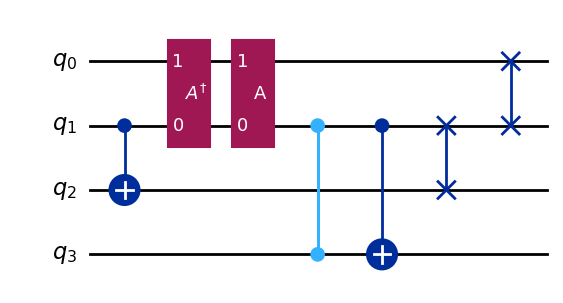

In [24]:
inserted_qc.draw("mpl")

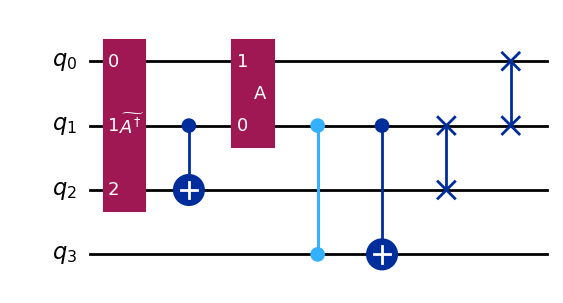

In [25]:
swapped_qc.draw("mpl")

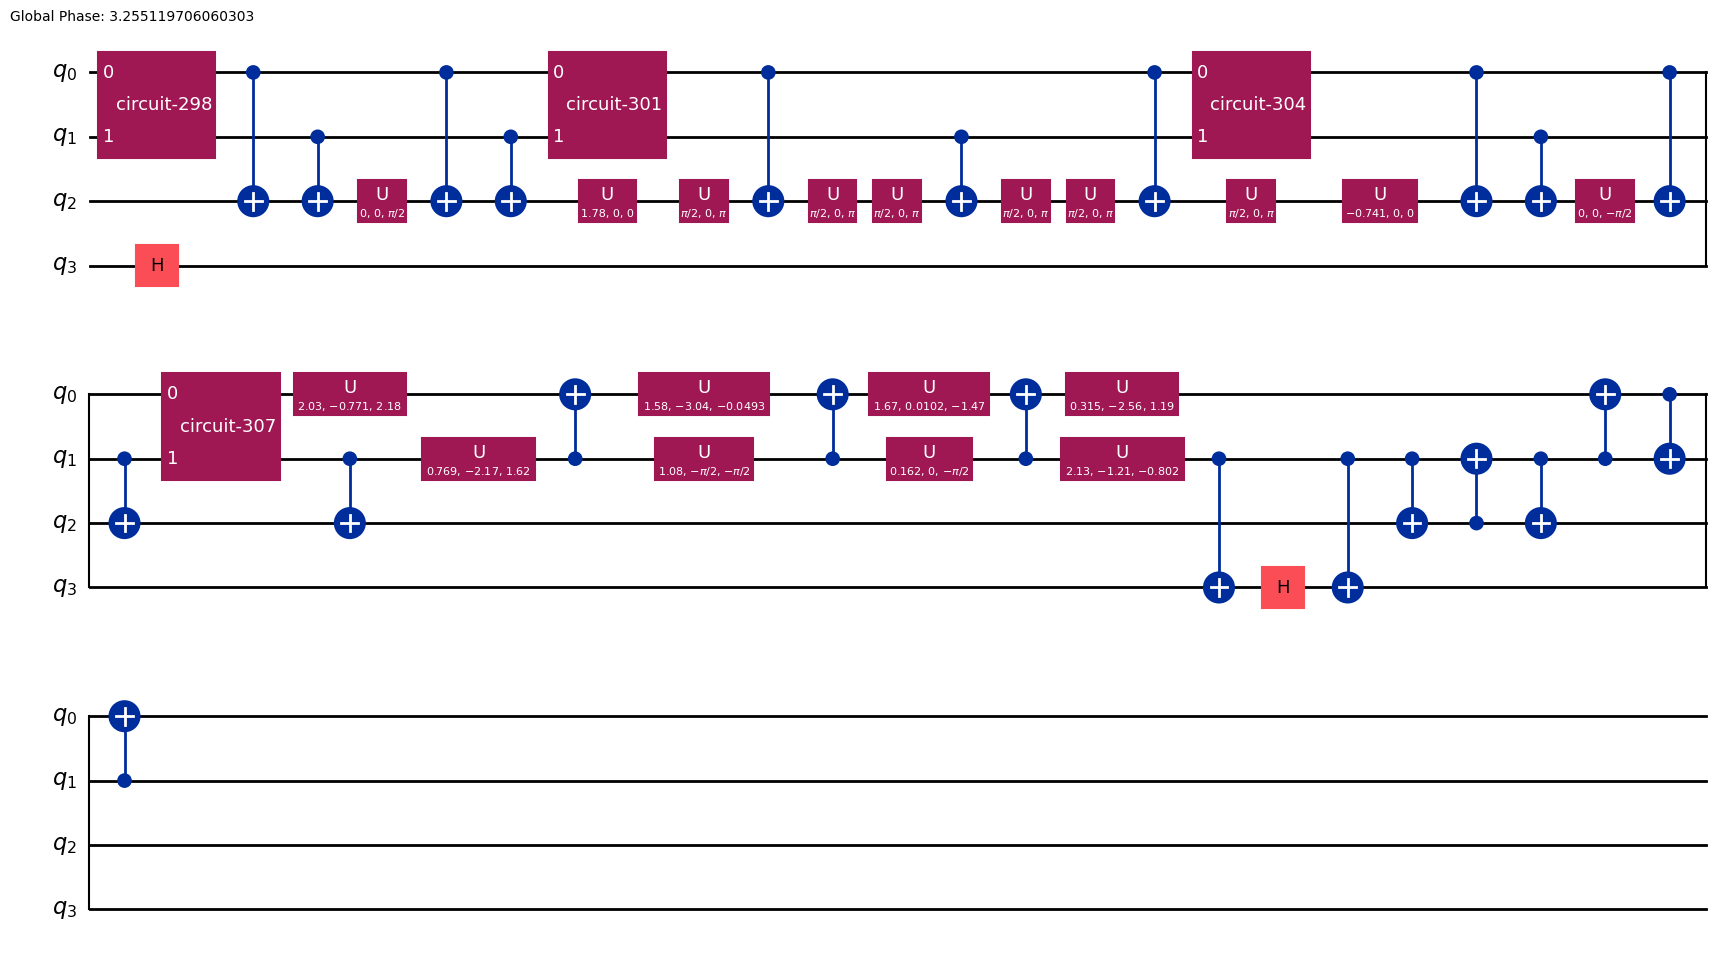

In [26]:
decomposed_qc.draw("mpl")

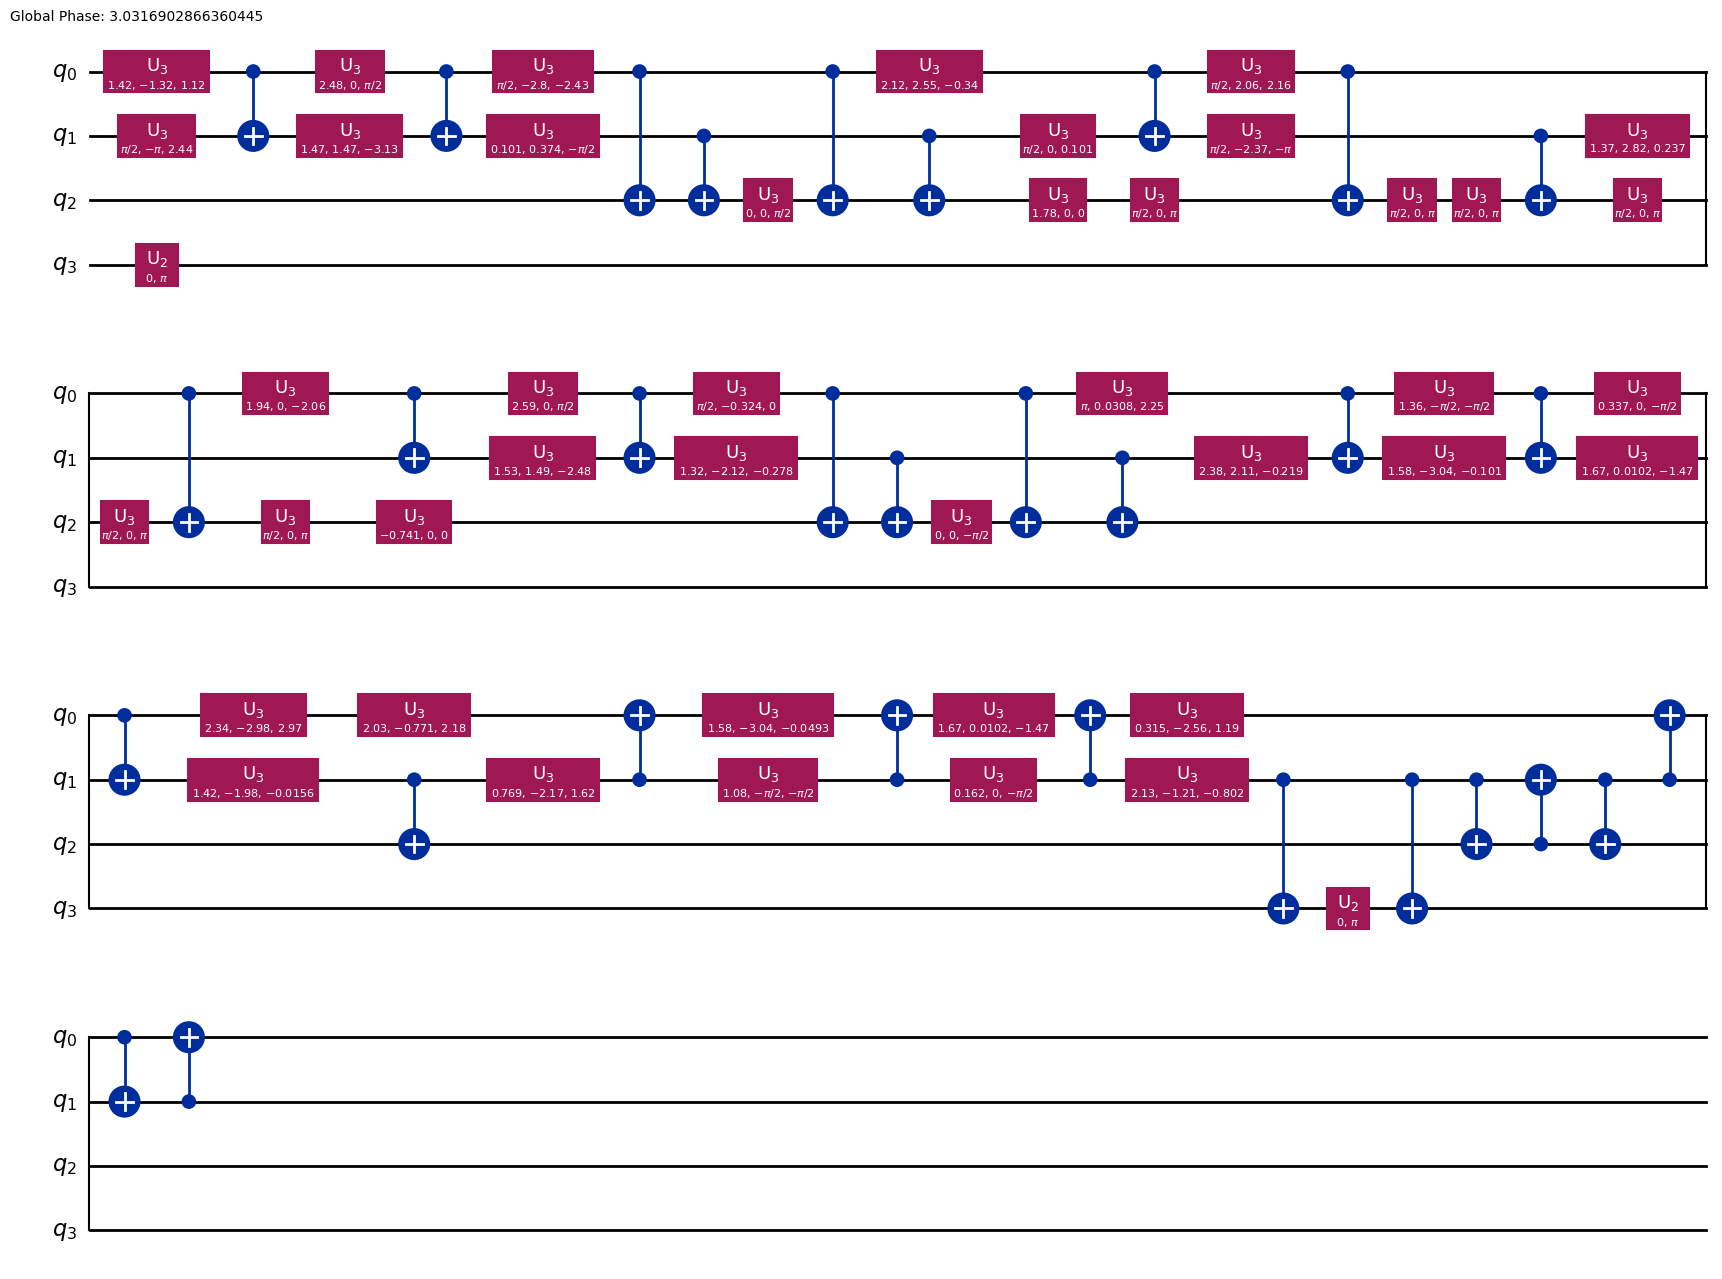

In [27]:
synthesized_qc.draw("mpl")

### Putting it all together: Applying the elementary recipe

In [28]:
def elementary_recipe(qc: QuantumCircuit, iterations=1, strategy="P_c"):
    """Apply the elementary recipe to a quantum circuit multiple times.

    Args:
        qc: The input quantum circuit.
        iterations: The number of times to apply the recipe.
        strategy: The strategy used in gate insertion. Options are "P_c" or "P_r".

    Returns:
        new_qc: The quantum circuit after applying the recipe.
    """
    new_qc = qc.copy()
    for _ in range(iterations):
        # Step 1: Gate Insertion
        new_qc, B1_info = gate_insert(new_qc, strategy)

        # Step 2: Gate Swapping
        new_qc = gate_swap(new_qc, B1_info)

        # Step 3: Decomposition
        new_qc = decompose_circuit(new_qc)

        # Step 4: Synthesis
        new_qc = synthesize_circuit(new_qc)

    return new_qc

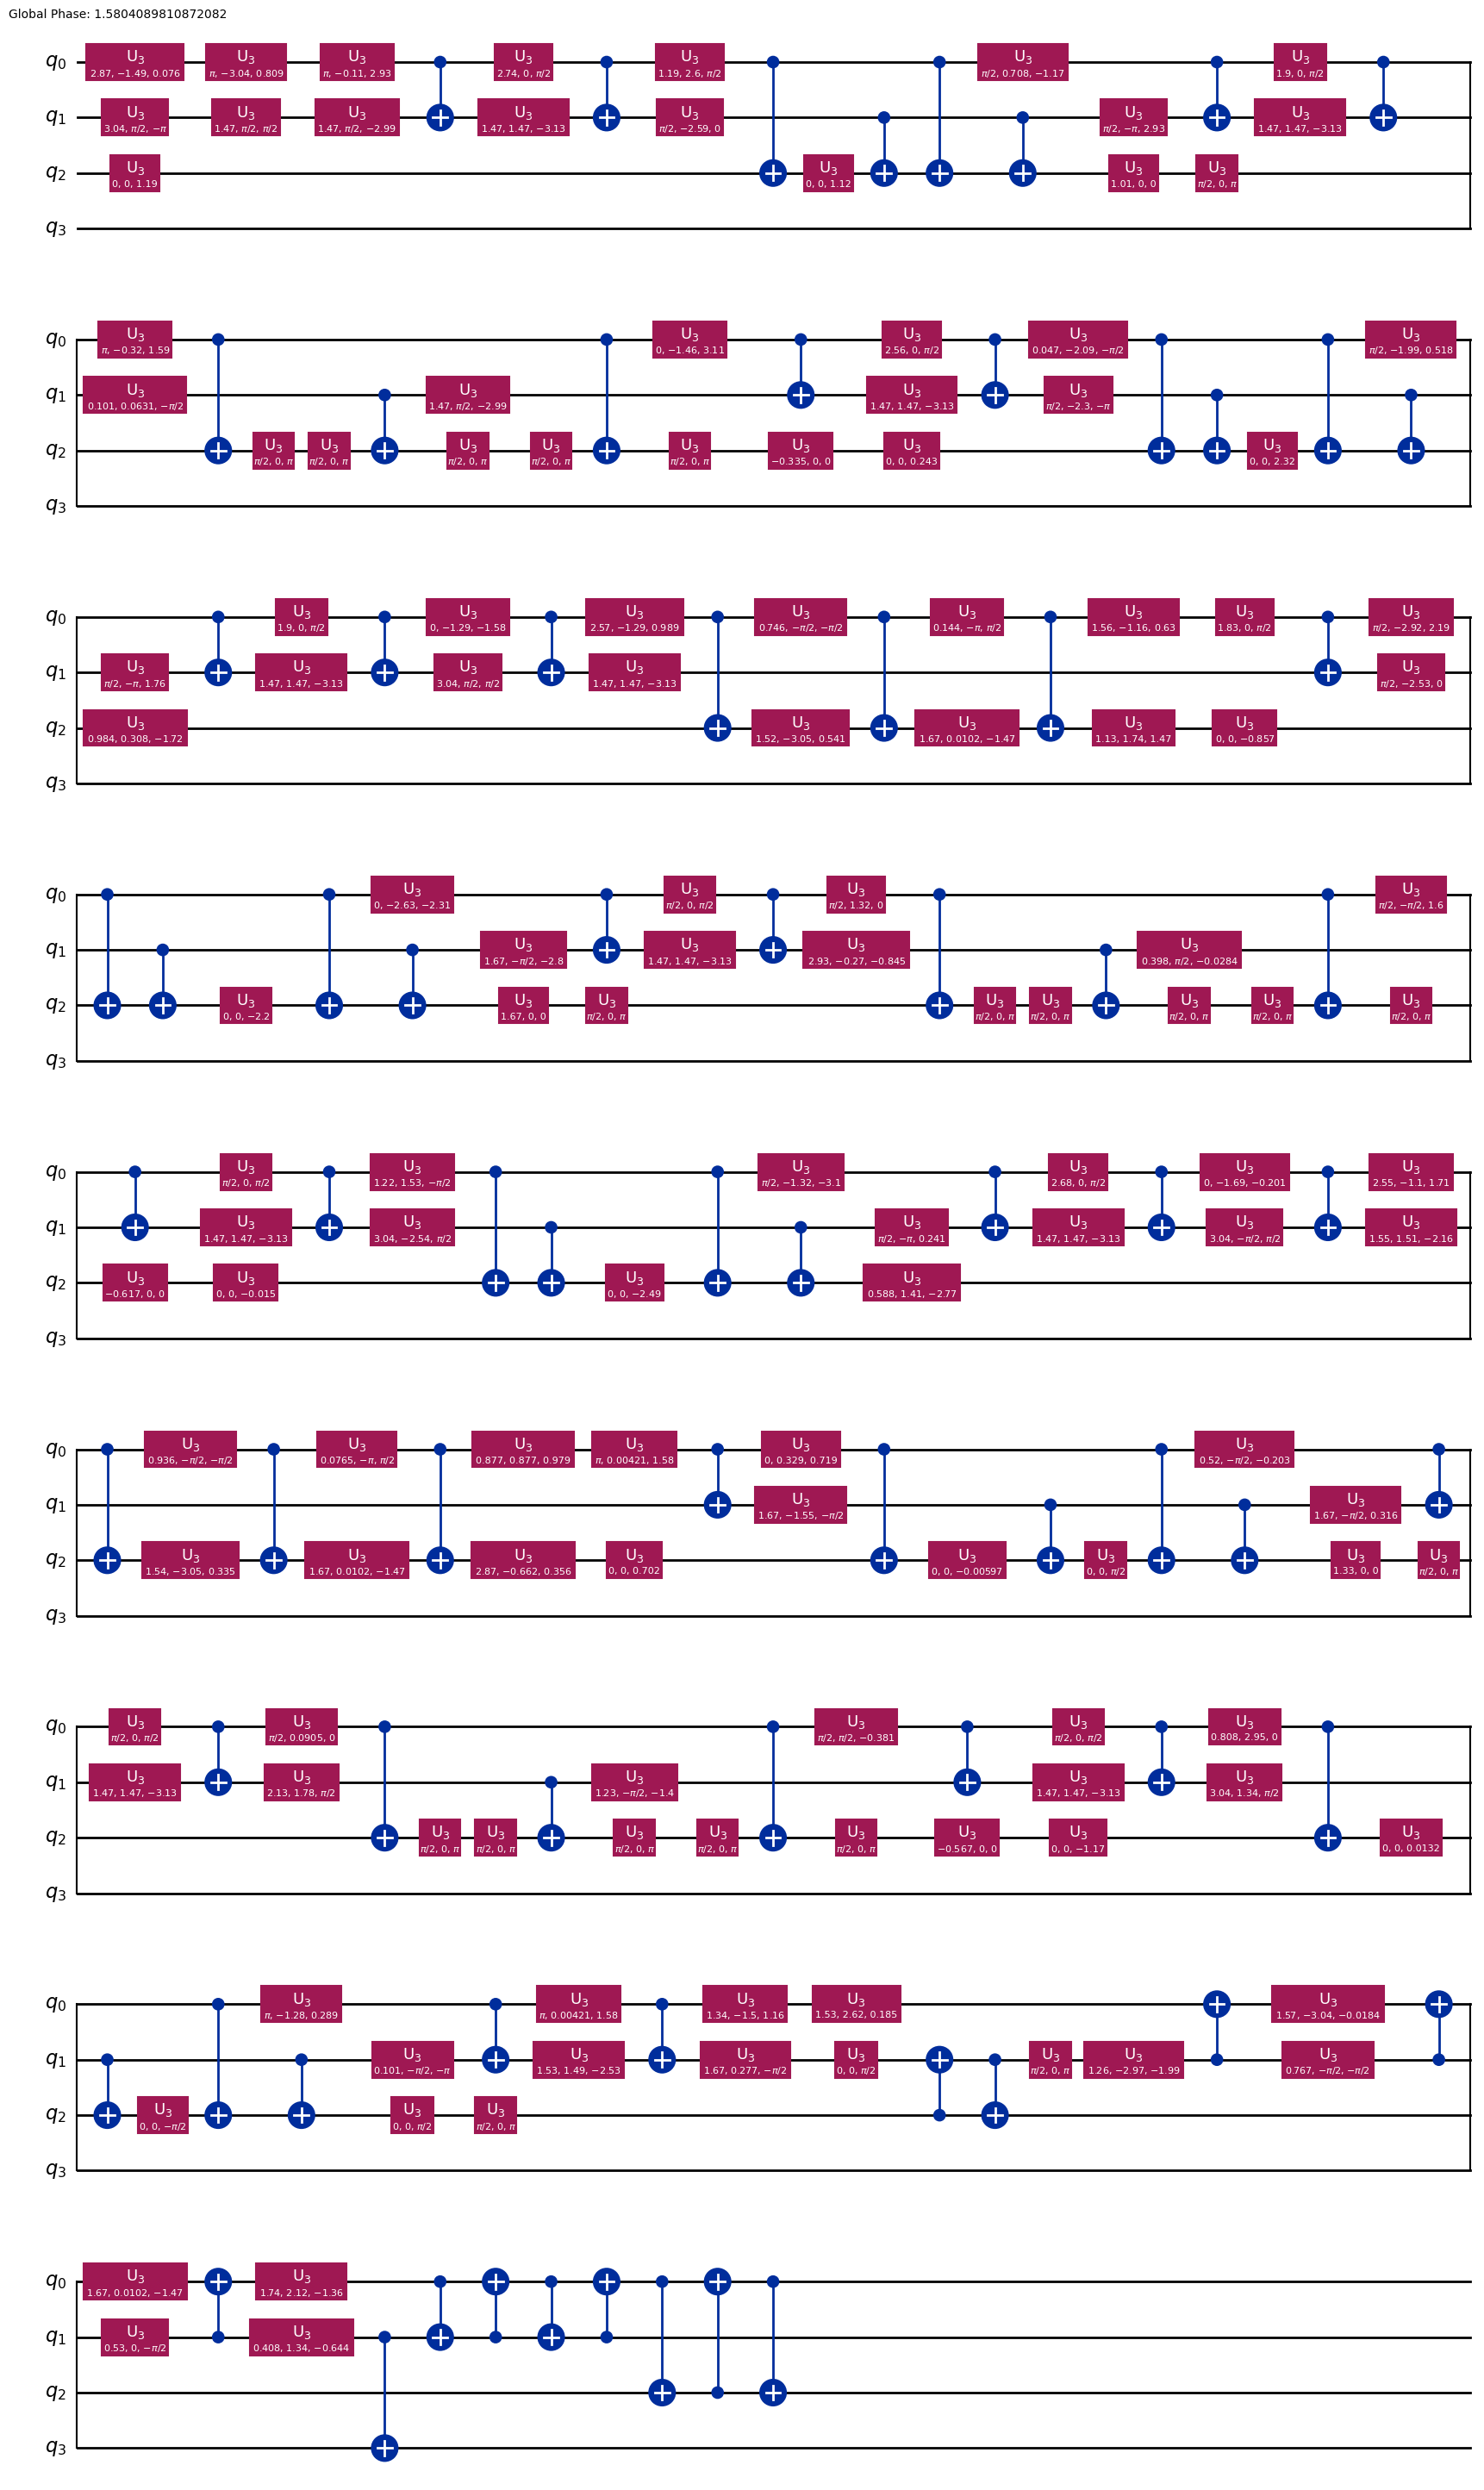

In [29]:
# Generate a random two-qubit circuit
qc = random_two_qubit_circuit(4, 5)

# Apply the elementary recipe 3 times
final_qc = elementary_recipe(qc, iterations=3)

# Print the final circuit
final_qc.draw("mpl")

In [30]:
qc = random_two_qubit_circuit(4, 5)
final_qc = elementary_recipe(qc, iterations=4)

original_unitary = Operator(qc)
final_unitary = Operator(final_qc)

unitaries_are_equal = original_unitary.equiv(final_unitary)

print(f"Are the circuits functionally equivalent? {unitaries_are_equal}")

Are the circuits functionally equivalent? True


## QEM and quantum circuit unoptimization

By unoptimizing the circuit using the `elementary_recipe`, we can create versions of the circuit with higher noise levels. Mitiq can be used to systematically scale the noise and perform the extrapolation. The unoptimized circuits can serve as intermediate noise levels for ZNE.

### Executor function for Mitiq

In [31]:
def execute(
    circuit: QuantumCircuit, 
    backend: Backend, 
    shots: float, 
    noise_model: NoiseModel | None = None
) -> float:
    """Executor for a Qiskit circuit."""    
    circuit_with_measurement = circuit.copy()
    circuit_with_measurement.measure_all()

    # Transpile the circuit:
    compiled_circuit = transpile(
        circuit_with_measurement, 
        backend, 
        basis_gates=noise_model.basis_gates if noise_model is not None else None,
        optimization_level=0,
    )
    
    # Execute the circuit:
    result = backend.run(compiled_circuit, noise_model=noise_model, shots=shots).result()
    counts = result.get_counts()

    # Calculate expectation value of Z on qubit 0
    total_counts = sum(counts.values())
    expectation = 0.0
    for outcome, count in counts.items():
        # Reverse the outcome string due to Qiskit's little-endian ordering
        bitstring = outcome[::-1]
        if bitstring[0] == "0":
            expectation += count / total_counts
        else:
            expectation -= count / total_counts
    return expectation

## ZNE via folding vs. ZNE via circuit unoptimization for noise-scaling

We want to compare scenarios in which we define a specific backend, noise model, and random circuit consisting of two-qubit gates. From this, we want to compare: 

- **ZNE (with noise-scaling via folding)**: Noise-scaling methods are done via folding (i.e. local, global, etc.) techniques that are typical for ZNE.
- **ZNE (with noise-scaling via circuit unoptimization)**: Noise-scaling methods are done via progressive iterations of the elementary recipe used in quantum circuit unoptimization to the input circuit.

In [32]:
# Hardware/simulator settings:
backend = AerSimulator()
noise_model = depolarizing_noise_model(error=0.01)
#noise_model = amplitude_damping_noise_model()
shots = 10_000

# ZNE settings:
#fold_method = zne.scaling.fold_gates_at_random
fold_method = zne.scaling.fold_global
extrapolation_method = zne.RichardsonFactory
scale_factors_fold = [1, 3, 5]

# Circuit unoptimization settings:
scale_factors_unopt = [1, 3, 5]
elementary_recipe_factors = [0, 2, 4]

# Circuit properties:
num_qubits = 5
depth = 15
qc = random_two_qubit_circuit(num_qubits=num_qubits, depth=depth)

# Ideal value for random circuit consisting of two-qubits will always be 1.
ideal_value = 1

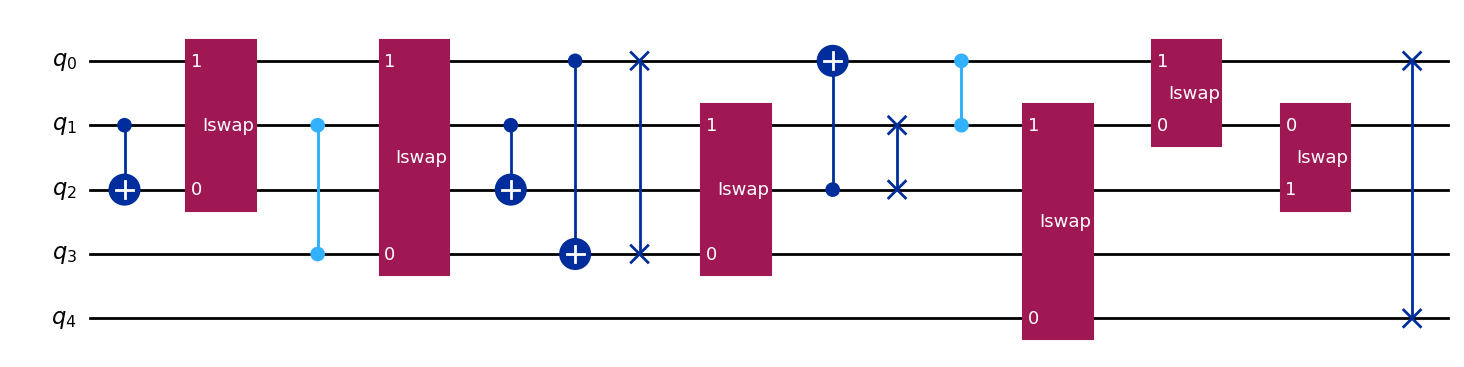

In [33]:
qc.draw("mpl")

### Unmitigated value

In [34]:
unmit_value = execute(circuit=qc, backend=backend, shots=shots, noise_model=noise_model)
print(f"Unmitigated value: {unmit_value}")

Unmitigated value: 0.8313999999999999


### ZNE via folding

Noise-scaled expectation values from fold_global: 
 [0.8228000000000001, 0.5678, 0.4006]
The RichardsonFactory zero-noise extrapolation is: 0.9832249999999997


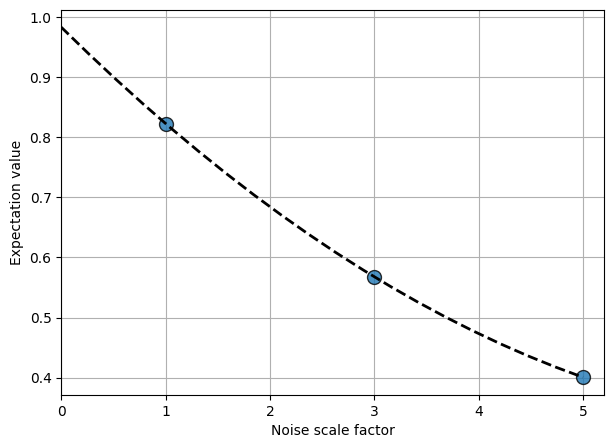

In [35]:
# Generate noise-scaled values via a list of folded circuits:
folded_circuits = [fold_method(qc, s) for s in scale_factors_fold]
folded_values = [execute(circuit=circ, backend=backend, shots=shots, noise_model=noise_model) for circ in folded_circuits]
print(f"Noise-scaled expectation values from {fold_method.__name__}: \n {folded_values}")

# Extrapolation:
factory = extrapolation_method(scale_factors_fold)
for s, val in zip(scale_factors_fold, folded_values):
    factory.push({"scale_factor": s}, val)

zne_fold_value = factory.reduce()
print(f"The {extrapolation_method.__name__} zero-noise extrapolation is: {zne_fold_value}")
_ = factory.plot_fit()

### ZNE via quantum circuit unoptimization

For ZNE via quantum circuit unoptimization, we want to progressively increase the depth (and thus noise) of a circuit through progressive applications of the elementary recipe. 

Noise-scaled expectation values from circuit unoptimization: 
 [0.8293999999999999, 0.2784, 0.15699999999999997]
The RichardsonFactory zero-noise extrapolation is 1.265999999999998


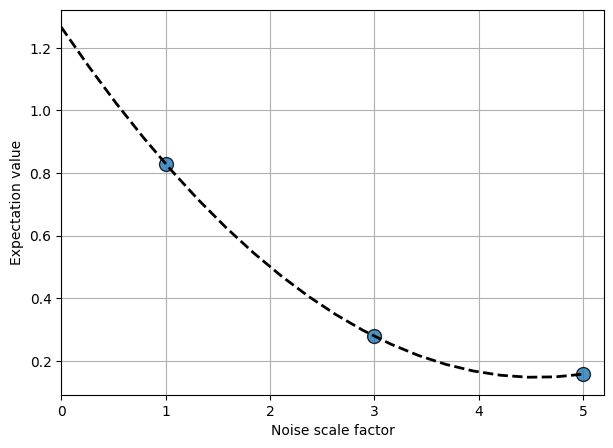

In [36]:
# Generate noise-scaled values via a the elementary recipe of circuit unoptimization:
unoptimized_circuits = [elementary_recipe(qc, iterations=i) for i in elementary_recipe_factors]
unoptimized_values = [execute(circuit=c, backend=backend, shots=shots, noise_model=noise_model) for c in unoptimized_circuits]
print(f"Noise-scaled expectation values from circuit unoptimization: \n {unoptimized_values}")

# Extrapolation:
factory = extrapolation_method(scale_factors_unopt)
for s, val in zip(scale_factors_unopt, unoptimized_values):
    factory.push({"scale_factor": s}, val)

zne_unopt_value = factory.reduce()
print(f"The {extrapolation_method.__name__} zero-noise extrapolation is {zne_unopt_value}")
_ = factory.plot_fit()

### Diagnostics

In [37]:
unmit_error = abs(ideal_value - unmit_value)
zne_fold_error = abs(ideal_value - zne_fold_value)
zne_unopt_error = abs(ideal_value - zne_unopt_value)

percent_improvement_unmit = ((unmit_error - zne_unopt_error) / zne_unopt_error) * 100
percent_improvement_zne_fold = ((zne_fold_error - zne_unopt_error) / zne_unopt_error) * 100

print("********************************************")
print(f"Unmitigated expectation value: {unmit_value}")
print(f"Unmitigated estimation error: {unmit_error}\n")

print(f"ZNE/fold expectation value: {zne_fold_value}")
print(f"ZNE/fold estimation error: {zne_fold_error}\n")  

print(f"ZNE/unopt expectation value: {zne_unopt_value}")
print(f"ZNE/unopt estimation error: {zne_unopt_error}\n")  

print(f"ZNE/unopt improvement over unmitigated: {percent_improvement_unmit:.2f}%")
print(f"ZNE/unopt improvement over ZNE/fold: {percent_improvement_zne_fold:.2f}%")
print("********************************************")

********************************************
Unmitigated expectation value: 0.8313999999999999
Unmitigated estimation error: 0.16860000000000008

ZNE/fold expectation value: 0.9832249999999997
ZNE/fold estimation error: 0.016775000000000317

ZNE/unopt expectation value: 1.265999999999998
ZNE/unopt estimation error: 0.265999999999998

ZNE/unopt improvement over unmitigated: -36.62%
ZNE/unopt improvement over ZNE/fold: -93.69%
********************************************
